## EAE 593 Presentation

### Project: A Synoptic Case Study of Atmospheric Rivers over the Eastern Pacific Ocean: Comparing Events with and without Mesoscale Frontal Waves and Secondary Cyclones 

###  Research Questions: 

1) What scale were the ARs?

2) How do the synoptic environments (e.g., frontal zones, mid-/upper-level trough, tropospheric jet streak) differ between the AR events?

3) If a mesoscale frontal wave and or secondary cyclone formed, where did they form relative to the AR?

###  To answer these questions, I used the ERA5 dataset which is available at  https://rda.ucar.edu/datasets/d633000/

### Import libraries such as Pandas, NumPy, and Matplotlib

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc


from siphon.catalog import TDSCatalog
from metpy.units import units
from scipy.ndimage import gaussian_filter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Defined function to download ERA5 data, merge it, and return it in an Xarray dataset

In [2]:
def load_datasets(year, month, start_day, start_hour=0, end_day=None, end_hour=23):
    # Set end_day to start_day if not provided
    if end_day is None:
        end_day = start_day
    
    # Get the last day of the month
    last_day_of_month = pd.Timestamp(year=year, month=month, day=1) + pd.offsets.MonthEnd(1)
    last_day_str = f"{last_day_of_month.day:02d}"  # format last day as two digits

    # Format date and time strings
    year_month = f'{year}{month:02d}'
    start_time = f'{year}{month:02d}{start_day:02d}{start_hour:02d}'  # yyyymmddhh (start)
    end_time = f'{year}{month:02d}{end_day:02d}{end_hour:02d}'  # yyyymmddhh (end)

    # Define URLs for pressure level datasets with specific time ranges
    urls = {
        'temperature_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_130_t.ll025sc.{start_time}_{end_time}.nc',
        'geopotential_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_129_z.ll025sc.{start_time}_{end_time}.nc',
        'humidity_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_133_q.ll025sc.{start_time}_{end_time}.nc',
        'v_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_132_v.ll025uv.{start_time}_{end_time}.nc',
        'u_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_131_u.ll025uv.{start_time}_{end_time}.nc',
        'w_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_135_w.ll025sc.{start_time}_{end_time}.nc',
        'pv_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_060_pv.ll025sc.{start_time}_{end_time}.nc',
        
        # Define URLs for surface datasets to cover the full month using last_day_of_month
        'mslp_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.128_151_msl.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc',
        'u_wind_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.228_131_u10n.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc',
        'v_wind_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.228_132_v10n.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc',
        'temperature_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.128_167_2t.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc',
        'dew_point_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.128_168_2d.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc'
    }

    # Initialize empty dictionaries for datasets
    datasets = {}

    # Try to load datasets from the URLs
    for var, url in urls.items():
        try:
            tds_catalog = TDSCatalog(url)
            ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
            ds = xr.open_dataset(ds_url).metpy.parse_cf()
            datasets[var] = ds
            print(f"Successfully loaded {var}")
            print("---")

        except Exception as e:
            print(f"Error loading {var}: {e}")
            print("---")

    # Try to merge pressure level datasets 
    ds_pl, ds_sfc = None, None

    try:
        ds_pl = xr.merge([datasets['temperature_pl'], datasets['geopotential_pl'], datasets['humidity_pl'], 
                        datasets['v_wind_pl'], datasets['u_wind_pl'], datasets['w_wind_pl'], datasets['pv_pl']])
        print("Successfully merged pressure level datasets")
    except KeyError as e:
        print(f"Error merging pressure level datasets: {e}")

    print("---")

    # Try to merge the sfc levvel datasets
    try:
        ds_sfc = xr.merge([datasets['mslp_sfc'], datasets['v_wind_sfc'], datasets['u_wind_sfc'],
                        datasets['temperature_sfc'], datasets['dew_point_sfc']])
        print("Successfully merged surface datasets")
    except KeyError as e:
        print(f"Error merging surface datasets: {e}")

    print("---")

    # Try to sync the time dimensions of the datasets since the surface dataset is monthly while the pressure level dataset is daily
    try:
        if ds_pl is not None and ds_sfc is not None:
            first_time_pl, last_time_pl = ds_pl['time'].min().values, ds_pl['time'].max().values
            ds_sfc = ds_sfc.sel(time=slice(first_time_pl, last_time_pl))
    except KeyError as e:
        print(f"Error accessing 'time' in the datasets: {e}")
    except Exception as e:
        print(f"An error occurred during slicing: {e}")

    print("Complete")

    return ds_pl, ds_sfc

### Defining relevant variables 

In [3]:
year = 2019 #yyyy
month = 2 #m or #mm
first_day = 13 #d or #dd
last_day = 14 #d or #dd
directions = {'North': 55, 
            'East': 250, 
            'South': 20, 
            'West': 200} # units: degrees North, degrees East
start_point = (30, 360 - 134) # units: degrees North, 360 - degrees West
end_point = (36, 360 - 127) # units: degrees North, 360 - degrees West
g = 9.81 # units: m/s^2

### For loop that calls the defined function to download ERA5 data

In [4]:
for start_day in range(first_day, last_day):
    ds_pl, ds_sfc = load_datasets(year, month, start_day, start_hour=0, end_day=None, end_hour=23)

C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded temperature_pl
---


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded geopotential_pl
---


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded humidity_pl
---


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded v_wind_pl
---


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded u_wind_pl
---


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_135_w.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_135_w.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded w_wind_pl
---


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded pv_pl
---


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded mslp_sfc
---


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded u_wind_sfc
---


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded v_wind_sfc
---


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_167_2t.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_167_2t.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded temperature_sfc
---


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_168_2d.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_168_2d.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded dew_point_sfc
---
Successfully merged pressure level datasets
---
Successfully merged surface datasets
---
Complete


### Pressure Level Dataset Structure

The dataset includes:

- **Dimensions**:  
  - Time  
  - Latitude  
  - Longitude  
  - Levels  

- **Variables**:  
  - **T**: Temperature  
  - **Z**: Geopotential  
  - **Q**: Specific humidity  
  - **V**: V-wind  
  - **U**: U-wind  
  - **W**: W-wind  
  - **PV**: Potential vorticity  


In [5]:
ds_pl

<xarray.Dataset>
Dimensions:    (time: 24, latitude: 721, level: 37, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 2019-02-13 ... 2019-02-13T23:00:00
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    metpy_crs  object Projection: latitude_longitude
Data variables:
    utc_date   (time) int32 2019021300 2019021301 ... 2019021322 2019021323
    T          (time, level, latitude, longitude) float32 ...
    Z          (time, level, latitude, longitude) float32 ...
    Q          (time, level, latitude, longitude) float32 ...
    V          (time, level, latitude, longitude) float32 ...
    U          (time, level, latitude, longitude) float32 ...
    W          (time, level, latitude, longitude) float32 ...
    PV         (time, level, latitude, longitude) float32 ...
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.6.3
    CONVERSION_PLATFORM:             Linux r9i2n12 4.12.14-94.41-default #1 S...
    CONVERSION_DATE:                 Tue Sep 10 17:07:15 MDT 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Tue Sep 10 17:07:34 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    DODS_EXTRA.Unlimited_Dimension:  time

### Surface level dataset structure:

The dataset includes:

- **Dimensions**:  
  - Time  
  - Latitude  
  - Longitude  

- **Variables**:  
  - **MSL**: Mean-Sea Level Pressure  
  - **VAR_2T**: 2m Temperature  
  - **VAR_2D**: 2m Dewpoint   
  - **V10N**: 10m V-wind  
  - **U10N**: 10m U-wind  


In [6]:
ds_sfc

<xarray.Dataset>
Dimensions:    (time: 24, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 2019-02-13 ... 2019-02-13T23:00:00
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    metpy_crs  object Projection: latitude_longitude
Data variables:
    utc_date   (time) int32 2019021300 2019021301 ... 2019021322 2019021323
    MSL        (time, latitude, longitude) float32 ...
    V10N       (time, latitude, longitude) float32 ...
    U10N       (time, latitude, longitude) float32 ...
    VAR_2T     (time, latitude, longitude) float32 ...
    VAR_2D     (time, latitude, longitude) float32 ...
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB1 da...
    NETCDF_VERSION:                  4.6.3
    CONVERSION_PLATFORM:             Linux r8i7n29 4.12.14-94.41-default #1 S...
    CONVERSION_DATE:                 Tue Sep 10 16:39:23 MDT 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Tue Sep 10 16:39:39 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    DODS_EXTRA.Unlimited_Dimension:  time

### AR Scale from Ralph et. al (2019)

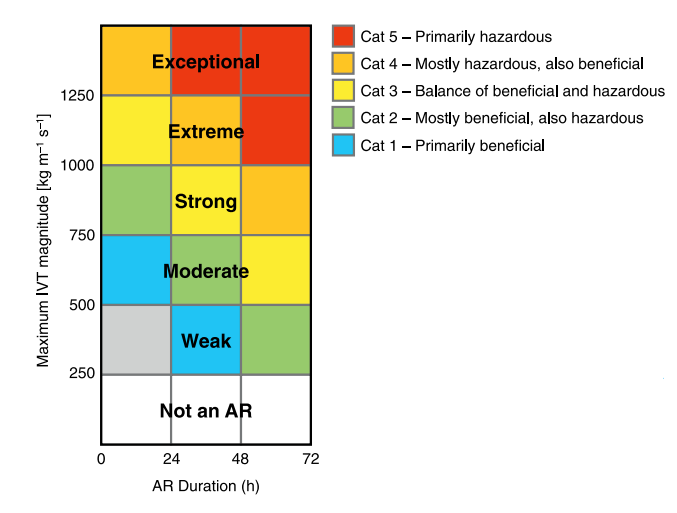


$$
IVT = -\frac{1}{g} \int_{p_0}^{p_t} qV \, dp
$$

$$ g = 9.81 \, \mathrm{m \, s^{-2}}, \quad p_0 = 1000 \, \mathrm{hPa}, \quad p_t = 150 \, \mathrm{hPa}, \quad q \text{ is specific humidity, and } V \text{ is the total horizontal wind.} $$


### Defined function that calculates IVT and plots it

In [7]:
def plot_ivt(g, ds_pl, ds_sfc, directions):
    # Loop over the reanlysis time steps
    for i in range(19, 20):
        # Slice the dataset to get the data for the current time step
        ds_sliced = ds_pl.isel(time=i)
        ds_sfc_sliced = ds_sfc.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_sliced = ds_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Slice the dataset to get the data for the pressure levels between 500 and 1000 hPa
        u_sliced = ds_sliced['U'].sel(level=slice(150, 1000)) # units: m/s
        v_sliced = ds_sliced['V'].sel(level=slice(150, 1000)) # units: m/s
        q_sliced = ds_sliced['Q'].sel(level=slice(150, 1000)) # units: kg/kg

        mslp = ds_sfc_sliced['MSL'] / 100 # units: hPa

        # Flip the order of the pressure levels and convert them to Pa from hPa
        pressure_levels = u_sliced.level[::-1] * 100 # units: Pa

        # Calculate the integrated vapor transport (IVT) using the u- and v-wind components and the specific humidity
        u_ivt = -1 / g * np.trapz(u_sliced * q_sliced, pressure_levels, axis=0)
        v_ivt = -1 / g * np.trapz(v_sliced * q_sliced, pressure_levels, axis=0)

        # Calculate the IVT magnitude
        ivt = np.sqrt(u_ivt**2 + v_ivt**2)

        # Create an xarray DataArray for the IVT
        ivt_da = xr.DataArray(ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        # Define the color levels and colors for the IVT plot
        levels = [250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1600, 1800]
        colors = ['#ffff00', '#ffe400', '#ffc800', '#ffad00', '#ff8200', '#ff5000', '#ff1e00', '#eb0010', '#b8003a', '#850063', '#570088']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Create the figure
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the IVT
        c = plt.contour(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), colors='black', levels=levels, linewidths=0.5)
        cf = plt.contourf(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), cmap=cmap, levels=levels, norm=norm, extend='max')
        plt.colorbar(cf, orientation='vertical', label='IVT (kg/m/s)', fraction=0.046, pad=0.04)

        # Mask the IVT values below 250 kg/m/s and create a filtered DataArray for the u- and v-wind components
        mask = ivt_da >= 250
        u_ivt_filtered = xr.DataArray(u_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)
        v_ivt_filtered = xr.DataArray(v_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)

        # Plot the IVT vectors
        step = 5 
        plt.quiver(u_ivt_filtered['longitude'][::step], u_ivt_filtered['latitude'][::step], u_ivt_filtered[::step, ::step], v_ivt_filtered[::step, ::step], scale=500,scale_units='xy', color='black')
        
        # Contour the isobars
        isobars = plt.contour(mslp['longitude'], mslp['latitude'], gaussian_filter(mslp, sigma=1), colors='black', levels=np.arange(960, 1080, 4), linewidths=0.5)
        
        # Try and except to avoid any IndexErrors
        try:
            plt.clabel(isobars, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        except IndexError:
            print("No contours to label for isobars.")

        # Adding custom legend entries
        isobars_line = plt.Line2D([0], [0], color='black', linewidth=1, label='MSLP (hPa)')

        # Creating the legend with the custom entries
        ax.legend(handles=[isobars_line], loc='upper right')

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis Integrated Water Vapor Transport (IVT) | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='#ecf9fd')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')
        gls = ax.gridlines(draw_labels=False, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        ax.set_xticks(ax.get_xticks(), crs=ccrs.PlateCarree())
        ax.set_yticks(ax.get_yticks(), crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter()
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        plt.tight_layout()
        plt.show()

### Call the defined function that calculates and plots the IVT

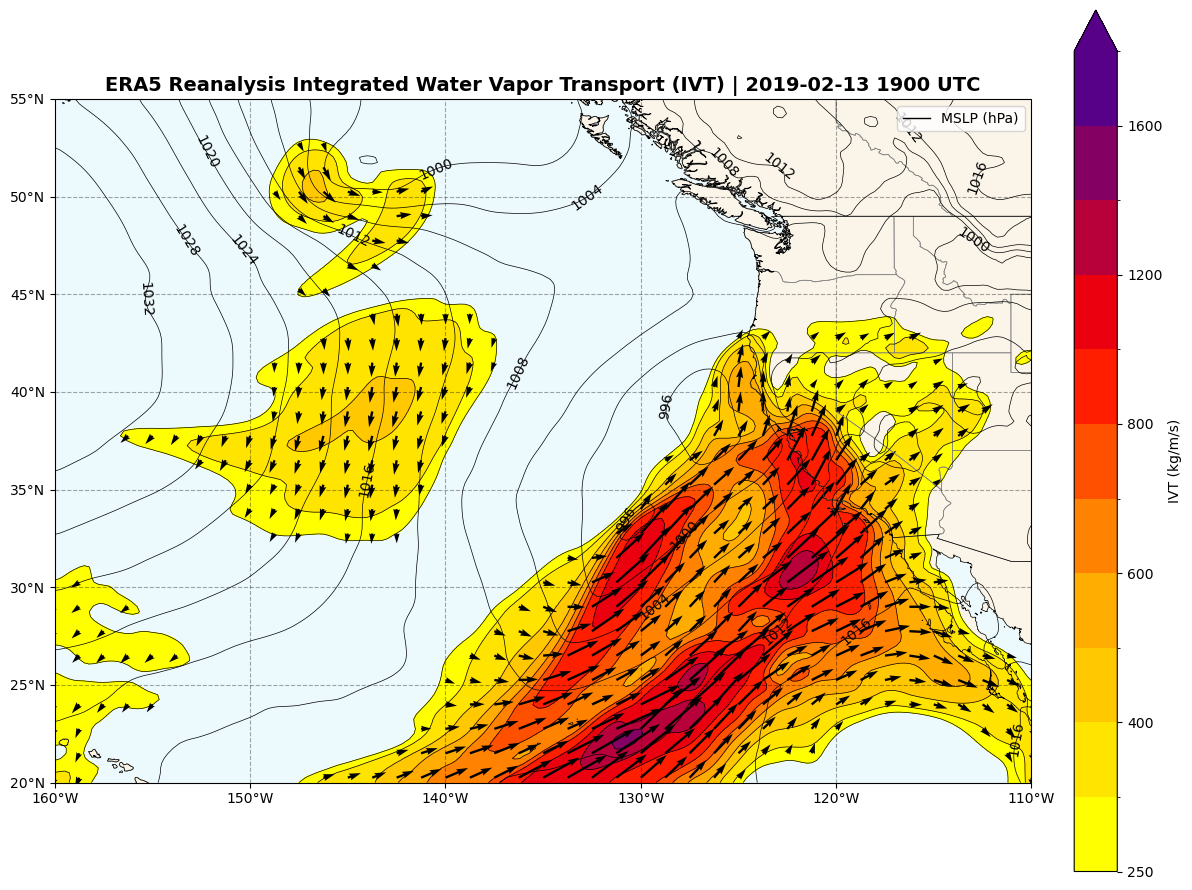

In [8]:
plot_ivt(g=g, ds_pl=ds_pl, ds_sfc=ds_sfc, directions=directions)

### Defined function that plots the upper-tropospheric total wind and 1000-500 hPa thickness

In [9]:
def plot_250_isotachs_thickness(ds_pl, directions, g):
    # Loop over the reanalysis time steps
    for i in range(19, 20):
        ds_pl_sliced = ds_pl.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        
        # Slice the dataset to get the data for the pressure level at 250 hPa
        u_250 = ds_pl_sliced['U'].sel(level=250) * units.meter / units.second # units: m/s
        v_250 = ds_pl_sliced['V'].sel(level=250) * units.meter / units.second  # units: m/s
        gp = ds_pl_sliced['Z'] * (units.meter**2) / (units.second**2) # units: m
        gph = gp / (g * units.meter / (units.second**2))
        pressure_levels = u_250.level * 100 # units: Pa

        # Geopotential Height
        gph_250 = gph.sel(level=250) # units: m

        # Calculate the thickness of the layer between 1000 and 500 hPa
        thickness = gph.sel(level=500) - gph.sel(level=1000)

        # Calculate the wind speed at 250 hPa
        wind_speed_250 = np.sqrt(u_250**2 + v_250**2)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Smooth the mslp, thickness, and total wind
        geopotential_height_smoothed = gaussian_filter(gph_250, sigma=3)
        thickness_smoothed = gaussian_filter(thickness, sigma=3)
        wnd_smoothed = gaussian_filter(wind_speed_250, sigma=3)

        # Create the figure 
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Contour the thickness
        thickness_c = plt.contour(thickness['longitude'], thickness['latitude'], thickness_smoothed, colors='red', levels=np.arange(4000,7000,100), linewidths=2, linestyles='dashed')

        # Try and except to avoid any IndexErrors
        try:
            ax.clabel(thickness_c, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        except IndexError:
            print("No contours to label.")

        # Shade the 250-hPa wind speed    
        cf = plt.contourf(u_250['longitude'], u_250['latitude'], wnd_smoothed, cmap="BuPu", levels=np.arange(30,105,5), extend='max')
        plt.colorbar(cf, orientation='vertical', label='Wind Speed (ms$^{-1}$)', fraction=0.046, pad=0.04)

        # Plot the 250-hPa wind barbs
        step = 10
        ax.barbs(u_250['longitude'][::step], u_250['latitude'][::step], u_250[::step, ::step], v_250[::step, ::step], length=6, color='black')

        # Adding custom legend entries
        isohypse_line = plt.Line2D([0], [0], color='black', linewidth=1, label='Geopotential Height (m)')
        thickness_lines = plt.Line2D([0], [0], color='red', linestyle = "dashed", linewidth=2, label='1000-500 hPa Thickness (m)')

        # Creating the legend with the custom entries
        ax.legend(handles=[thickness_lines], loc='upper right')

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis 250-hPa Isoatachs, 1000-500-hPa Thickness, and Barbs | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North'] - 5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='#ecf9fd')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')
        gls = ax.gridlines(draw_labels=False, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        ax.set_xticks(ax.get_xticks(), crs=ccrs.PlateCarree())
        ax.set_yticks(ax.get_yticks(), crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter()
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        plt.tight_layout()
        plt.show()

### Call the defined function that plots the upper-tropospheric total wind and 1000-500 hPa thickness

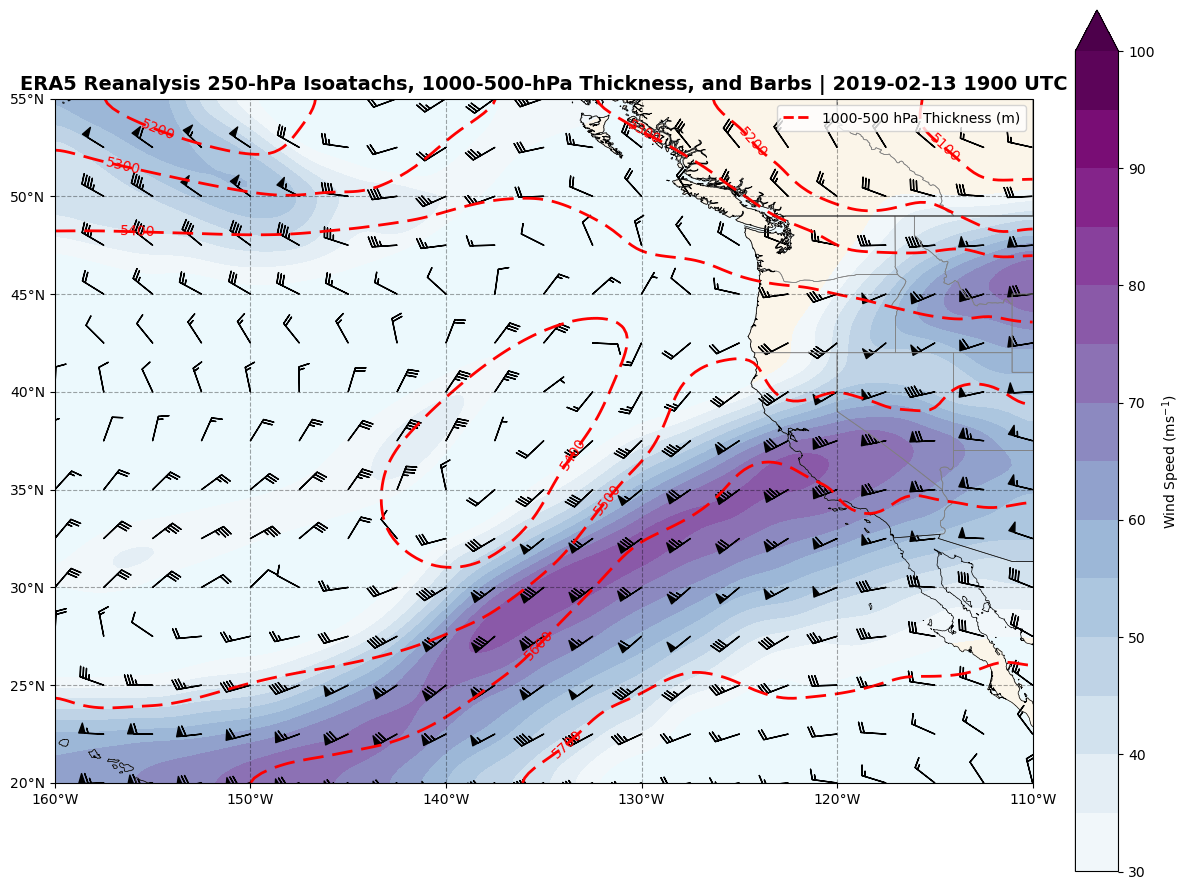

In [10]:
plot_250_isotachs_thickness(ds_pl=ds_pl, directions=directions, g=g)

### Defined function that calculates potential temperature and IVT, and plots a vertical cross-section through the mesoscale frontal wave

In [11]:
def theta_pv_cross_section(start_point=start_point, end_point=end_point, ds_pl=ds_pl, directions=directions, g=g):
    # Loop over the reanalysis time steps
    for i in range(19, 20):
        ds_pl_sliced = ds_pl.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Get the u, v, t, and q fields at multiple levels
        u_sliced = ds_pl_sliced['U'].sel(level=slice(150, 1000)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(150, 1000)) # units: m/s
        t_sliced = ds_pl_sliced['T'].sel(level=slice(150, 1000)) # units: K
        q_sliced = ds_pl_sliced['Q'].sel(level=slice(150, 1000)) # units: kg/kg
        pressure_levels = t_sliced['level'] # units: 
        pressure_levels_ivt = u_sliced.level[::-1] * 100 # units: Pa

        # Calculate potential temperature
        theta = mpcalc.potential_temperature(pressure_levels, t_sliced) # units: K

        # Add the potential temperature (theta) to the dataset
        theta_da = xr.DataArray(theta, dims=['level', 'latitude', 'longitude'],
                                coords={'level': t_sliced['level'], 
                                        'latitude': t_sliced['latitude'], 
                                        'longitude': t_sliced['longitude']},
                                attrs={'units': 'K'})

        ds_pl_sliced['THETA'] = theta_da

        # Calculate the integrated vapor transport (IVT) using the u- and v-wind components and the specific humidity
        u_ivt = -1 / g * np.trapz(u_sliced * q_sliced, pressure_levels_ivt, axis=0)
        v_ivt = -1 / g * np.trapz(v_sliced * q_sliced, pressure_levels_ivt, axis=0)

        # Calculate the IVT magnitude
        ivt = np.sqrt(u_ivt**2 + v_ivt**2)

        # Create an xarray DataArray for the IVT
        ivt_da = xr.DataArray(ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        # Define the color levels and colors for the IVT plot
        ivt_levels = [250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1600, 1800]
        ivt_colors = ['#ffff00', '#ffe400', '#ffc800', '#ffad00', '#ff8200', '#ff5000', '#ff1e00', '#eb0010', '#b8003a', '#850063', '#570088']
        ivt_cmap = mcolors.ListedColormap(ivt_colors)
        ivt_norm = mcolors.BoundaryNorm(ivt_levels, ivt_cmap.N)

        # Mask the IVT values below 250 kg/m/s and create a filtered DataArray for the u- and v-wind components
        mask = ivt_da >= 250
        u_ivt_filtered = xr.DataArray(u_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)
        v_ivt_filtered = xr.DataArray(v_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Now do the cross-section interpolation
        lat_values = np.linspace(start_point[0], end_point[0])
        lon_values = np.linspace(start_point[1], end_point[1])
        x = xr.DataArray(lon_values, dims='Lat_Lon')
        y = xr.DataArray(lat_values, dims='Lat_Lon')
        
        # Interpolate the sliced data for the cross-section
        ds_cross = ds_pl_sliced.interp(longitude=x, latitude=y, method='nearest')

        # Pull the PV and potential temperature  from the cross section dataset
        pv_crossed = ds_cross['PV'].sel(level=slice(150, 1000)) # units: K
        theta_crossed = ds_cross['THETA'].sel(level=slice(150, 1000)) # units: K

        # Get the pressure levels
        pressure_levels = pv_crossed['level'] # units: hPa

        # Define the color levels and colors for the potential vorticity
        levels = np.arange(0, 3.26, 0.25)
        colors = ['white', '#d1e9f7', '#a5cdec', '#79a3d5', '#69999b', '#78af58', '#b0cc58', '#f0d95f', '#de903e', '#cb5428', '#b6282a', '#9b1622', '#7a1419']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Smooth the PV and potential temperature 
        pv_smoothed = gaussian_filter(pv_crossed, sigma=1)
        theta_smoothed = gaussian_filter(theta_crossed, sigma=1)

        # Create the figure 
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the isentropes and potential vorticity 
        isentropes = ax.contour(ds_cross['longitude'], pressure_levels, theta_smoothed, colors='black', levels=np.arange(250, 450, 1))
        ax.clabel(isentropes, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        pv_cf = ax.contourf(ds_cross['longitude'], pressure_levels, pv_smoothed * 1e6, cmap=cmap, levels=levels, norm=norm, extend='max')
        plt.colorbar(pv_cf, orientation='vertical', label='PV (m$^2$ s$^{-1}$ K kg$^{-1}$)', fraction=0.046, pad=0.04)

        # Adding the isentropes to the legend with a custom label
        theta_line = plt.Line2D([0], [0], color='black', linewidth=1, label=r'$\theta$ Potential Temperature (K)')

        # Creating the legend with the custom entries
        ax.legend(handles=[theta_line], loc='upper right')
        ax.set_yticks(pressure_levels)
        ax.set_yticklabels(list(pressure_levels.values))
        plt.ylim(1000, 600)
        plt.xlabel('Longitude (degrees E)')
        plt.ylabel('Pressure (hPa)')
        plt.title(f'ERA5 Reanalysis Vertical Cross-Section of PV and $\\theta$ | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}')

        # Set y-axis tick marks
        custom_ticks = [1000, 900, 800, 700, 600]  
        ax.set_yticks(custom_ticks)
        ax.set_yticklabels([str(tick) for tick in custom_ticks])

        # Add labels "A" and "A'" to the bottom left and right
        ax.text(0, -0.1, 'A', transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='left', fontweight='bold')
        ax.text(1, -0.1, "A'", transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')

        # Add an inset of the plan view to provide additional context 
        ax_inset = fig.add_axes([0.10, 0.63, 0.25, 0.25], projection=ccrs.PlateCarree())
        ax_inset.set_extent([directions['East'], directions['West'], directions['South'], directions['North']])
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.OCEAN, color='white')
        ax_inset.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax_inset.add_feature(cfeature.LAND, color='#fbf5e9')
        ax_inset.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]],
                            color="black", marker="o", transform=ccrs.PlateCarree())
        # Add text annotations
        ax_inset.text(start_point[1], start_point[0], "A", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)
        ax_inset.text(end_point[1], end_point[0], "A'", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)

        # Plot the IVT in the inset 
        c = ax_inset.contour(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), colors='black', levels=ivt_levels, linewidths=0.5)
        cf = ax_inset.contourf(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), cmap=ivt_cmap, levels=ivt_levels, norm=ivt_norm, extend='max')

        # Plot the IVT vectors
        step = 5 
        plt.quiver(u_ivt_filtered['longitude'][::step], u_ivt_filtered['latitude'][::step], u_ivt_filtered[::step, ::step], v_ivt_filtered[::step, ::step], scale=500,scale_units='xy', color='black')
        plt.show()

### Call the defined function that calculates potential temperature and IVT, and plots a vertical cross-section through the mesoscale frontal wave

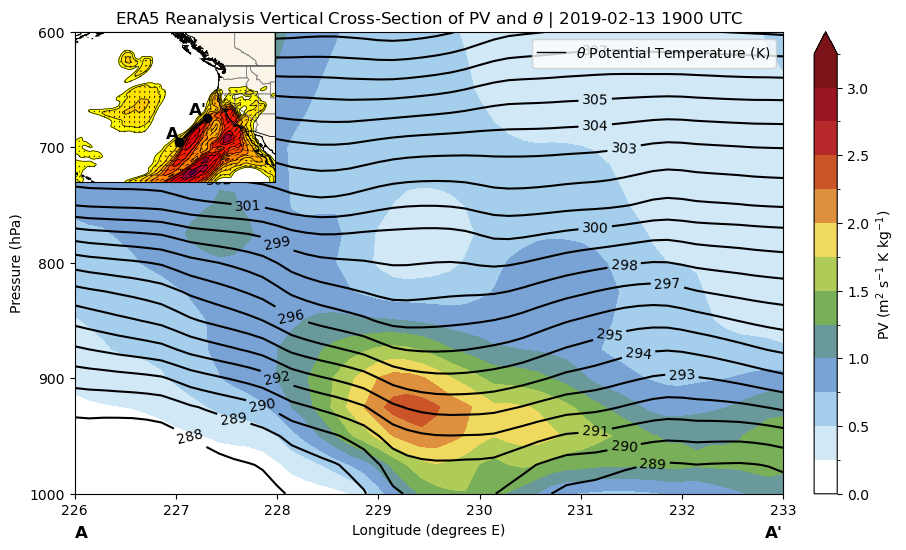

In [12]:
theta_pv_cross_section(start_point=start_point, end_point=end_point, ds_pl=ds_pl, directions=directions, g=g)

## Climate Prediction Center's (CPC) Daily Precipitation

### Defined function that downloads the CPC's daily precipitation and returns it in an Xarray dataset

In [13]:
def get_precip_data(year, month, start_day, start_hour, end_day, end_hour, directions):
    year_string = str(year)
    url = f'https://psl.noaa.gov/thredds/catalog/Datasets/cpc_global_precip/catalog.html?dataset=Datasets/cpc_global_precip/precip.{year_string}.nc'
    tds_catalog = TDSCatalog(url)
    ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
    ds = xr.open_dataset(ds_url).metpy.parse_cf()
    first_time = pd.Timestamp(year, month, start_day, start_hour)
    last_time = pd.Timestamp(year, month, end_day, end_hour)
    ds_precip = ds.sel(time=slice(first_time, last_time))

    return ds_precip

### Define relevant variables and call the defined function that downloads the CPC daily precipitation data

In [14]:
year = 2019 #yyyy
month = 2 #m or #mm
start_day = 25 #d or #dd
start_hour = 0 # do not touch
end_day = 25 #d or #dd
end_hour = 23 # do not touch 

ds_precip = get_precip_data(year, month, start_day, start_hour, end_day, end_hour, directions)

C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://psl.noaa.gov/thredds/catalog/Datasets/cpc_global_precip/catalog.html?dataset=Datasets/cpc_global_precip/precip.2019.nc returned HTML. Changing to: https://psl.noaa.gov/thredds/catalog/Datasets/cpc_global_precip/catalog.xml?dataset=Datasets/cpc_global_precip/precip.2019.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


### Precipitation Dataset Structure

The dataset includes:

- **Dimensions**:  
  - Time  
  - Latitude  
  - Longitude  

- **Variables**:  
  - **precip**: Precipitation  

In [15]:
ds_precip

<xarray.Dataset>
Dimensions:    (lat: 360, lon: 720, time: 1)
Coordinates:
  * lat        (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon        (lon) float32 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time       (time) datetime64[ns] 2019-02-25
    metpy_crs  object Projection: latitude_longitude
Data variables:
    precip     (time, lat, lon) float32 ...
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.4.1.1|hdf5l...
    Conventions:                     CF-1.0
    Source:                          ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_U...
    version:                         V1.0
    title:                           CPC GLOBAL PRCP V1.0 RT
    dataset_title:                   CPC GLOBAL PRCP V1.0
    dataset:                         CPC Global Precipitation
    history:                         Updated 2020-01-02 23:31:10
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    DODS_EXTRA.Unlimited_Dimension:  time

### Defined function that plots the CPC's daily precipitation

In [16]:
def plot_precip(ds, directions):
    for i in range (0, 1):
        ds = ds.isel(time=i)
        time = ds.time.values
        int_datetime_index = pd.DatetimeIndex([time])
        levels = [0.3, 2.5, 6.4, 12.7, 19.1, 25.4, 38.1, 50.8, 63.5, 76.2]
        colors = ['#c9e7f0', '#95cbd5', '#6f98d0', '#45539e', '#8fbf5c', '#80ba55', '#568a4c', '#e4e44e', '#dcba60', '#d08c39', '#c43b33']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Create the figure 
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the precipitation
        precip = ax.contourf(ds['lon'], ds['lat'], ds['precip'], levels=levels, cmap=cmap, extend='max', norm=norm)
        plt.colorbar(precip, ax=ax, orientation='vertical', label='mm/day', fraction=0.046, pad=0.04)
        
        # Add the title, set the map extent, and add map features        
        plt.title(f'CPC 24-Hour Precipitation Analysis for {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}')
        ax.set_extent([directions['West']+25, directions['East'], 30, directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='#ecf9fd')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False

        plt.tight_layout()
        plt.show()

### Call the defined function that plots the CPC's daily precipitation 

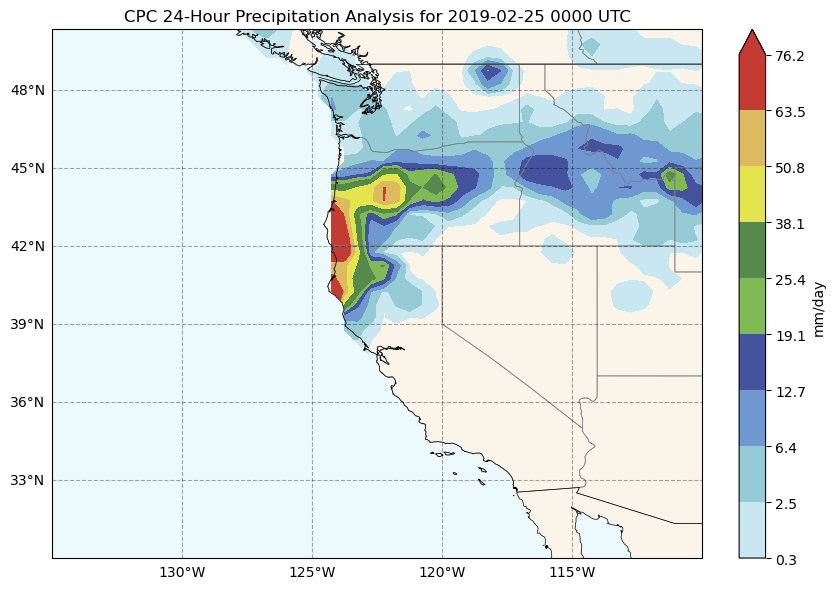

In [17]:
plot_precip(ds=ds_precip, directions=directions)

### References

Chen, M., W. Shi, P. Xie, V. B. S. Silva, V. E. Kousky, R. Wayne Higgins, and J. E. Janowiak, 2008: Assessing objective techniques for gauge‐based analyses of global daily precipitation. J. Geophys. Res., 113, 2007JD009132, https://doi.org/10.1029/2007JD009132.

Hersbach, H., and Coauthors, 2020: The ERA5 global reanalysis. Quarterly Journal of the Royal Meteorological Society, 146, 1999–2049, https://doi.org/10.1002/qj.3803.

Ralph, F. M., J. J. Rutz, J. M. Cordeira, M. Dettinger, M. Anderson, D. Reynolds, L. J. Schick, and C. Smallcomb, 2019: A Scale to Characterize the Strength and Impacts of Atmospheric Rivers. https://doi.org/10.1175/BAMS-D-18-0023.1.